In [1]:
import sys
#sys.path.insert(0,'/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/marusy/Programming/another-fem-framework/')
sys.path.insert(0,'/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [33]:
from operator_assembler.assembly_interface import AssemblyInterface2D
from operator_assembler.n_to_1_ddof_allocator import Nto1Allocator2D
from grid.grid_manager import GridManager
from grid.allocator_interface import InterfaceDofAllocator2D
from grid.grid_domain import GridDomain
from operator_assembler.matrix_assembler import MatrixAssembler2D
from scipy.ndimage import imread
from grid import cell, grid_layer, grid_manager
import h5py
import numpy as np

from interpolant.cell_to_points import *
from common import visual
from common.tests import *
from common.helpers import *
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, dok_matrix, coo_matrix
from scipy.sparse import linalg

from matplotlib.collections import  LineCollection

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 10

In [3]:
np.set_printoptions(linewidth=500)

#### Bad cell

In [17]:
ran = 16
data = np.ones((ran,ran))
for i,j in itertools.product(range(ran), repeat=2):
    if i>=j:
        data[i,j] = 2

In [18]:
data_start = (150, 114)
data_shape = (16, 16)
data_end = tuple([i+j for i,j in zip(data_start, data_shape)])

#h5_data = h5py.File('../../../GM_L3D/600/state/viz_GM_1.h5')['index'][0]
#data = h5_data[data_start[0]:data_end[0], data_start[1]:data_end[1]]
#data = imread('/Users/leonshting/Programming/Schlumberger/model/bhi2_labelled0000.tif')[data_start[0]:data_end[0], data_start[1]:data_end[1]]

grid_domain = GridDomain(integer_size=data_shape, domain_size=(1.,1.))
gm = GridManager(method_options={'max_coarsening_layer':100})
ifma = InterfaceDofAllocator2D(grid_manager=gm.fit(data=data))

In [ ]:
cell15 = cell.Cell2D(size=(1,1), ll_vertex=(0,8))
cell25 = cell.Cell2D(size=(1,1), ll_vertex=(0,9))

cell14 = cell.Cell2D(size=(1,1), ll_vertex=(0,6))
cell24 = cell.Cell2D(size=(1,1), ll_vertex=(0,7))

cell13 = cell.Cell2D(size=(1,1), ll_vertex=(0,4))
cell23 = cell.Cell2D(size=(1,1), ll_vertex=(0,5))

cell12 = cell.Cell2D(size=(1,1), ll_vertex=(0,2))
cell22 = cell.Cell2D(size=(1,1), ll_vertex=(0,3))

cell1 = cell.Cell2D(size=(1,1), ll_vertex=(0,0))
cell2 = cell.Cell2D(size=(1,1), ll_vertex=(0,1))

cell3 = cell.Cell2D(size=(2,2), ll_vertex=(1,0))
cell32 = cell.Cell2D(size=(2,2), ll_vertex=(1,2))
cell33 = cell.Cell2D(size=(2,2), ll_vertex=(1,4))
cell34 = cell.Cell2D(size=(2,2), ll_vertex=(1,6))
cell35 = cell.Cell2D(size=(2,2), ll_vertex=(1,8))

In [ ]:
layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2, cell12, cell22, cell13, cell23, cell14, cell24, cell15, cell25]], layer_number=0, index=[1,1], div_index=[1,1])
layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3, cell32, cell33, cell34, cell35]], layer_number=1, index=[1], div_index=[1])

#layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2]], layer_number=0, index=[1,1], div_index=[1,1])
#layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3]], layer_number=1, index=[1], div_index=[1])

In [ ]:
gm = grid_manager.GridManager(dim=2, method='coarse2to1')
gm.grid_layers = [layer1, layer2]
ifma = InterfaceDofAllocator2D(grid_manager=gm)

## setting the order of BF
#ifma._default_order = 3

In [ ]:
ma = Nto1Allocator2D(grid_interface=ifma)
ma.make_complete_index()

In [ ]:
grid_domain = GridDomain(domain_size=(1.,1.), integer_size=(16,16))
grid_domain.make_pointwise_index(ma)

In [ ]:
ifma2 = AssemblyInterface2D(allocator=ma)
MA = MatrixAssembler2D(assembly_interface=ifma2, grid_domain=grid_domain)

In [ ]:
MA.assemble_whole_dist(alpha=0.5)

In [ ]:
MA.assemble_glob_local(normed=False)

In [ ]:
MA.assemble_mass_glob_local()

In [ ]:
new = MA.unmerged * MA.whole_dist
new_ass = MA.whole_dist.T * MA.unmerged * MA.whole_dist
flux_new = MA.whole_dist.T * MA.unmerged

In [ ]:
plt.spy(new_ass,markersize=1)

In [ ]:
MA.unmerged.shape

In [ ]:
sine_test = grid_domain.vectorize_function(lambda x,y: np.sin(x+y))
product = grid_domain.devectorize_vector(new_ass * sine_test)
init = grid_domain.devectorize_function(lambda x,y: np.sin(x+y))

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_vector(new_ass * sine_test),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

#visual.plot_surface_unstructured_w_dict(
#    point_val_dict=grid_domain.devectorize_function(lambda x,y: np.sin(x+y)),
#    plot_domain_shape=grid_domain.domain_size,
#    int_domain_shape=grid_domain.integer_size
#)

In [23]:
l = gm.grid_layers[1]

In [29]:
def divide_cell(cell):
    from grid.cell import Cell2D
    cells = []
    start = cell.ll_vertex
    step = cell.size[0]//2
    for dx,dy in itertools.product([0,1], repeat=2):
        new_cell = Cell2D(size=(step, step), ll_vertex=(start[0] + dx, start[1] + dy))
        cells.append(new_cell)
    return cells

In [36]:
newshit = []
for cell in l.iterate_cells():
    if cell.ll_vertex[0] == cell.ll_vertex[1] - 2:
        newshit.extend(divide_cell(cell))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


AttributeError: 'NoneType' object has no attribute 'set_visible'

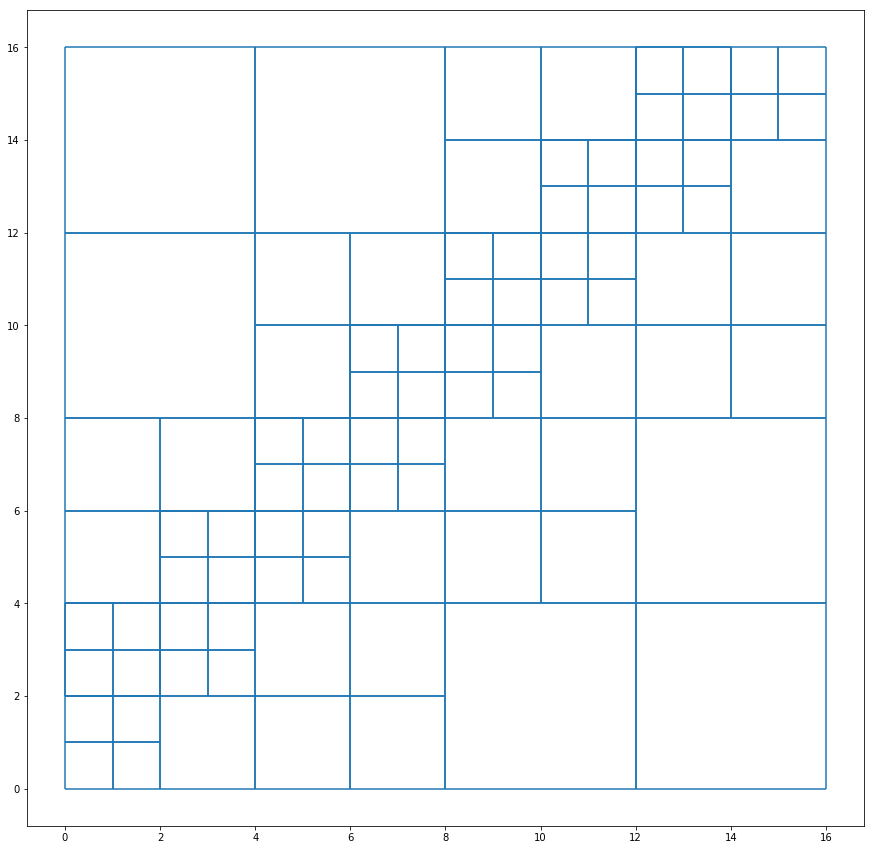

In [40]:
f,ax = gm.draw_grid()
lines = []
for cell in newshit:
    for edge in cell.iterate_edges():
        lines.append(edge)
lines = LineCollection(lines)
ax.add_collection(lines)
ax.legend().set_visible(False)
ax.imshow(data, cmap='BuPu',extent=[16, 0, 0, 16])


In [ ]:
grid_domain.pointwise_index[(.125, 1.)]

In [ ]:
for i in {21}:
    print(i, end=' ')
    partial_diff_test(matrix=flux_new,
                      point=grid_domain.normal_index[i],
                      pointnum=i,
                      pointdict=grid_domain.pointwise_index,
                      scale_factor=1
                     )

In [ ]:
for i in {23, 73}:
    print(i, end=' ')
    partial_diff_test(matrix=new_ass,
                      point=grid_domain.normal_index[i],
                      pointnum=i,
                      pointdict=grid_domain.pointwise_index,
                      scale_factor=1
                     )

In [ ]:
-0.010416681320460724 / -0.010875741644591074

In [ ]:
-0.0416667252818429 / -0.0435029665783643

In [ ]:
-0.1666669011273716 / -0.1740118663134572

In [ ]:
for i in {23, 73}:
    print(i, end=' ')
    partial_diff_test(matrix=new_ass,
                      point=grid_domain.normal_index[i],
                      pointnum=i,
                      pointdict=grid_domain.pointwise_index,
                      scale_factor=1
                     )

In [ ]:
w = np.array([0.042,  0.208,  0.208,  0.083,  0.208,  0.208,  0.042])
w_t = concat_arrays_with_adjacency(w,w,)

In [ ]:
coefs = np.array([-0.026, 0.035, -0.008, -0.042, -0.069, 0.168, 0.801])
coefs_t = np.hstack([coefs, coefs[:-1][::-1]])

In [ ]:
0.11/0.042

In [ ]:
sum(w_t*coefs_t)

In [ ]:
pipka = wdt.T * MA.unmerged

In [ ]:
wdt[247].sum(axis=1)

In [ ]:
MA.whole_dist[419].sum()

In [ ]:
np.argsort(np.array(MA.dist.sum(axis=1)).flatten())

In [ ]:
plt.imshow(MA.dist.toarray())

In [ ]:
a = np.array([0.5, 0.54])

In [ ]:
a**0.5

In [ ]:
new_eff